In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy
import requests 
import os 
import datetime
from scipy import stats
import netCDF4 as nc
import scipy.optimize as opt
from mpl_toolkits.basemap import Basemap

In [2]:
stn_coord=pd.read_csv('../data/observation/coords.csv')
stn=stn_coord['stn']
stn_lat=stn_coord['lat']
stn_lon=stn_coord['lon']

In [3]:
# Daily visibility data for 47 stations in Nigeria from Dec 2021 to Mar 2022
vis=pd.read_csv('../data/observation/vis_12_2021_03_2022.csv', index_col=[0])
vis.index=pd.to_datetime(vis.index, format='%d/%m/%Y')
vis.head()

,ABK,ABE,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YOL,ZAR,YEN
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,10.0,13.0,10.0,12.0,10.0,10.0,10.0,10.0,10.0,10.0,...,NaN,10.0,10.0,16.0,6.0,20.0,5.3,10.0,8.0,10.0
2021-12-02,10.0,10.0,10.0,10.0,8.0,10.0,10.0,1.5,10.0,10.0,...,NaN,20.0,7.0,NaN,10.0,20.0,20.0,1.0,3.0,NaN
2021-12-03,10.0,13.0,3.0,13.0,10.0,10.0,10.0,1.0,10.0,1.0,...,NaN,20.0,3.0,15.0,7.0,20.0,1.5,1.6,1.0,10.0
2021-12-04,8.0,12.0,5.0,4.5,8.0,8.0,8.0,6.0,6.0,1.0,...,NaN,15.0,4.0,8.0,8.0,10.0,1.5,2.0,2.0,10.0
2021-12-05,7.0,8.0,4.0,3.0,5.0,8.0,8.0,8.0,7.0,1.0,...,NaN,2.5,10.0,7.0,3.0,NaN,3.5,5.0,10.0,10.0


In [4]:
# cap visibility maximum to 10km
# training set from Dec 2021 to Jan 2022, possible to add Feb?, validation for Mar??
vis.columns
for i in vis.columns:
    vis[i]=np.where(vis[i]>10, 10, vis[i])
vis_train=vis.iloc[:90]
vis_test=vis.iloc[90:]
vis.head()

,ABK,ABE,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YOL,ZAR,YEN
date,,,,,,,,,,,,,,,,,,,,,
2021-12-01,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,NaN,10.0,10.0,10.0,6.0,10.0,5.3,10.0,8.0,10.0
2021-12-02,10.0,10.0,10.0,10.0,8.0,10.0,10.0,1.5,10.0,10.0,...,NaN,10.0,7.0,NaN,10.0,10.0,10.0,1.0,3.0,NaN
2021-12-03,10.0,10.0,3.0,10.0,10.0,10.0,10.0,1.0,10.0,1.0,...,NaN,10.0,3.0,10.0,7.0,10.0,1.5,1.6,1.0,10.0
2021-12-04,8.0,10.0,5.0,4.5,8.0,8.0,8.0,6.0,6.0,1.0,...,NaN,10.0,4.0,8.0,8.0,10.0,1.5,2.0,2.0,10.0
2021-12-05,7.0,8.0,4.0,3.0,5.0,8.0,8.0,8.0,7.0,1.0,...,NaN,2.5,10.0,7.0,3.0,NaN,3.5,5.0,10.0,10.0


In [5]:
bsc = xr.open_dataset("../data/models/SILAM/2021120100_SILAM.nc")
bsc

<xarray.Dataset>
Dimensions:     (time: 25, lat: 376, lon: 476)
Coordinates:
  * time        (time) datetime64[ns] 2021-12-01 ... 2021-12-04
  * lat         (lat) float32 -5.0 -4.8 -4.6 -4.4 -4.2 ... 69.4 69.6 69.8 70.0
  * lon         (lon) float32 -30.0 -29.8 -29.6 -29.4 ... 64.4 64.6 64.8 65.0
Data variables:
    SCONC_DUST  (time, lat, lon) float32 ...
    OD550_DUST  (time, lat, lon) float32 ...
Attributes: (12/18)
    Conventions:                CF-1.4
    source:                     silam_v5_7 SVN (r596360)
    SIMULATION_START_DATE:      2021-11-28T00:00:00Z
    grid_projection:            lonlat
    pole_lat:                   -90.0
    pole_lon:                   0.0
    ...                         ...
    geospatial_lat_min:         -5.0
    geospatial_lat_max:         70.00000762939453
    geospatial_lon_min:         -30.0
    geospatial_lon_max:         65.0
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    history_of_appended_files:  Thu Dec  2 01:00:04 2021: Appended file out-s...

In [6]:
# ('SILAM', 'SCONC_DUST', (11, 19), 1000000000)

In [7]:
nc_files = os.listdir(f"../data/models/SILAM")
nc_files[0]

'2022031700_SILAM.nc'

In [8]:
# sconc_dust #
day1_lead_all = pd.DataFrame(columns=["stn", "lon", "lat"])
for nc_file in nc_files:
    bsc = xr.open_dataset("../data/models/SILAM/"+nc_file)
    day1_lead = [["stn", "lon", "lat", bsc.SCONC_DUST.time.to_series()[11]]]
    for i in range(len(stn)):
        day1_bsc = bsc.SCONC_DUST.isel(time = 11).sel(lat = stn_lat[i], 
                                                     lon = stn_lon[i], 
                                                     method = 'nearest')*1000000000
        day1_lead.append([stn[i], stn_lon[i], stn_lat[i], day1_bsc.to_dict()["data"]])
    day1_lead = pd.DataFrame(day1_lead[1:len(day1_lead)], columns = day1_lead[0])
    day1_lead_all = day1_lead_all.merge(day1_lead, 
                                        on = ["stn", "lon", "lat"], 
                                        how = "outer")
#data for 1 day leadtime for all sations
day1_lead_all

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
/home/nwp/anaconda3/lib/python3.9/site-packages/xarray/core/indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], m

,stn,lon,lat,2022-03-18 09:00:00,2021-12-09 09:00:00,2022-03-30 09:00:00,2022-02-24 09:00:00,2022-01-04 09:00:00,2022-02-11 09:00:00,2022-01-30 09:00:00,...,2021-12-05 09:00:00,2021-12-30 09:00:00,2022-02-01 09:00:00,2022-03-20 09:00:00,2022-02-08 09:00:00,2022-04-01 09:00:00,2022-01-02 09:00:00,2022-01-10 09:00:00,2022-03-29 09:00:00,2022-03-12 09:00:00
0,ABE,3.33,7.20,0.080401,6.006318,0.074024,4.541119,21.944302,73.894626,675.208923,...,6.291001,0.167348,222.587715,0.010104,82.072816,0.012705,1.616172,1.862676,0.008296,0.004329
1,ABK,8.19,6.25,0.437396,0.583775,0.167955,0.424321,392.607888,16.172280,834.470256,...,9.307855,0.243311,759.031082,0.019451,66.167686,0.186919,22.585567,0.796736,0.047763,0.003858
2,ABU,7.20,9.00,472.705267,755.305678,5.561446,335.276354,676.609375,131.316824,315.252748,...,515.488182,87.428141,247.267081,3.518107,981.613994,0.158359,67.870140,156.927939,115.380878,0.707814
3,ADO,5.20,7.60,0.187555,14.457383,0.084709,5.883588,895.469270,34.927947,764.616004,...,14.948482,96.741132,198.605051,0.009089,104.017097,0.006972,112.224363,11.474364,0.356465,0.003523
4,AKU,5.30,7.20,0.060496,3.276940,0.016751,1.236266,410.713767,108.965608,819.564264,...,6.581145,28.609071,182.773206,0.001858,45.518405,0.010915,23.195753,11.008535,0.009599,0.005539
5,ASA,6.23,6.82,0.539032,1.156923,0.016983,2.521368,35.740694,24.985640,1161.359364,...,0.994586,2.105585,581.846109,0.001528,73.079732,0.006893,4.409232,2.990419,0.021487,0.004313
6,AWK,7.07,6.20,0.548852,0.124685,0.097440,0.119167,140.746849,73.284383,829.809892,...,0.522610,6.912207,800.008877,0.015394,103.376898,0.012907,1.244194,1.975423,0.044501,0.008306
7,BAU,9.82,10.28,1304.804073,1473.354018,665.945663,83.936129,1039.130439,1427.571988,1257.328108,...,321.888365,216.884871,2807.937335,234.460671,997.447842,450.770330,222.846424,1122.365461,2506.130841,2643.262633
8,BEN,5.60,6.33,0.958833,0.208762,0.020905,0.290587,2.439280,26.600905,1251.697768,...,1.242920,0.268371,693.836114,0.006459,57.538337,0.013572,4.365579,3.179594,0.079471,0.005809
9,BID,6.00,9.80,1041.261839,856.817394,587.676368,147.397941,568.576411,138.895075,464.289286,...,540.167719,144.122154,370.953330,18.525155,1329.011070,4.937859,119.675207,345.304898,651.014034,0.480213


In [9]:
day1_lead_all_t = day1_lead_all.transpose()
day1_lead_all_t.columns = day1_lead_all_t.iloc[0]
day1_lead_all_t = day1_lead_all_t.drop(["lon", "lat", "stn"])

# multiply AOD by 10
# day1_lead_all_t = day1_lead_all_t * 10

day1_lead_all_t = day1_lead_all_t.reset_index()

day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d").dt.date
day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d")
day1_lead_all_t = day1_lead_all_t.set_index("index")
day1_lead_all_t.head()

stn,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
index,,,,,,,,,,,,,,,,,,,,,
2022-03-18,0.080401,0.437396,472.705267,0.187555,0.060496,0.539032,0.548852,1304.804073,0.958833,1041.261839,...,1848.694524,0.177181,1194.888,2.508934,0.231388,1.26413,1173.475312,0.340795,1050.555852,1451.937578
2021-12-09,6.006318,0.583775,755.305678,14.457383,3.27694,1.156923,0.124685,1473.354018,0.208762,856.817394,...,5254.700227,36.147558,936.918923,0.533809,0.460672,0.16442,492.204038,1.672566,768.342943,1073.817884
2022-03-30,0.074024,0.167955,5.561446,0.084709,0.016751,0.016983,0.09744,665.945663,0.020905,587.676368,...,1311.283995,0.107882,487.582327,0.119908,1.650566,0.081417,776.745537,0.425079,514.129624,673.357988
2022-02-24,4.541119,0.424321,335.276354,5.883588,1.236266,2.521368,0.119167,83.936129,0.290587,147.397941,...,151.630957,1.060517,140.17678,0.130982,0.04542,0.223853,60.652717,0.061732,60.096227,87.663828
2022-01-04,21.944302,392.607888,676.609375,895.46927,410.713767,35.740694,140.746849,1039.130439,2.43928,568.576411,...,2498.272806,905.246623,1015.548946,16.036772,7.297861,0.780841,517.3506,2.267376,815.154635,1221.353159


/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/nwp/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py

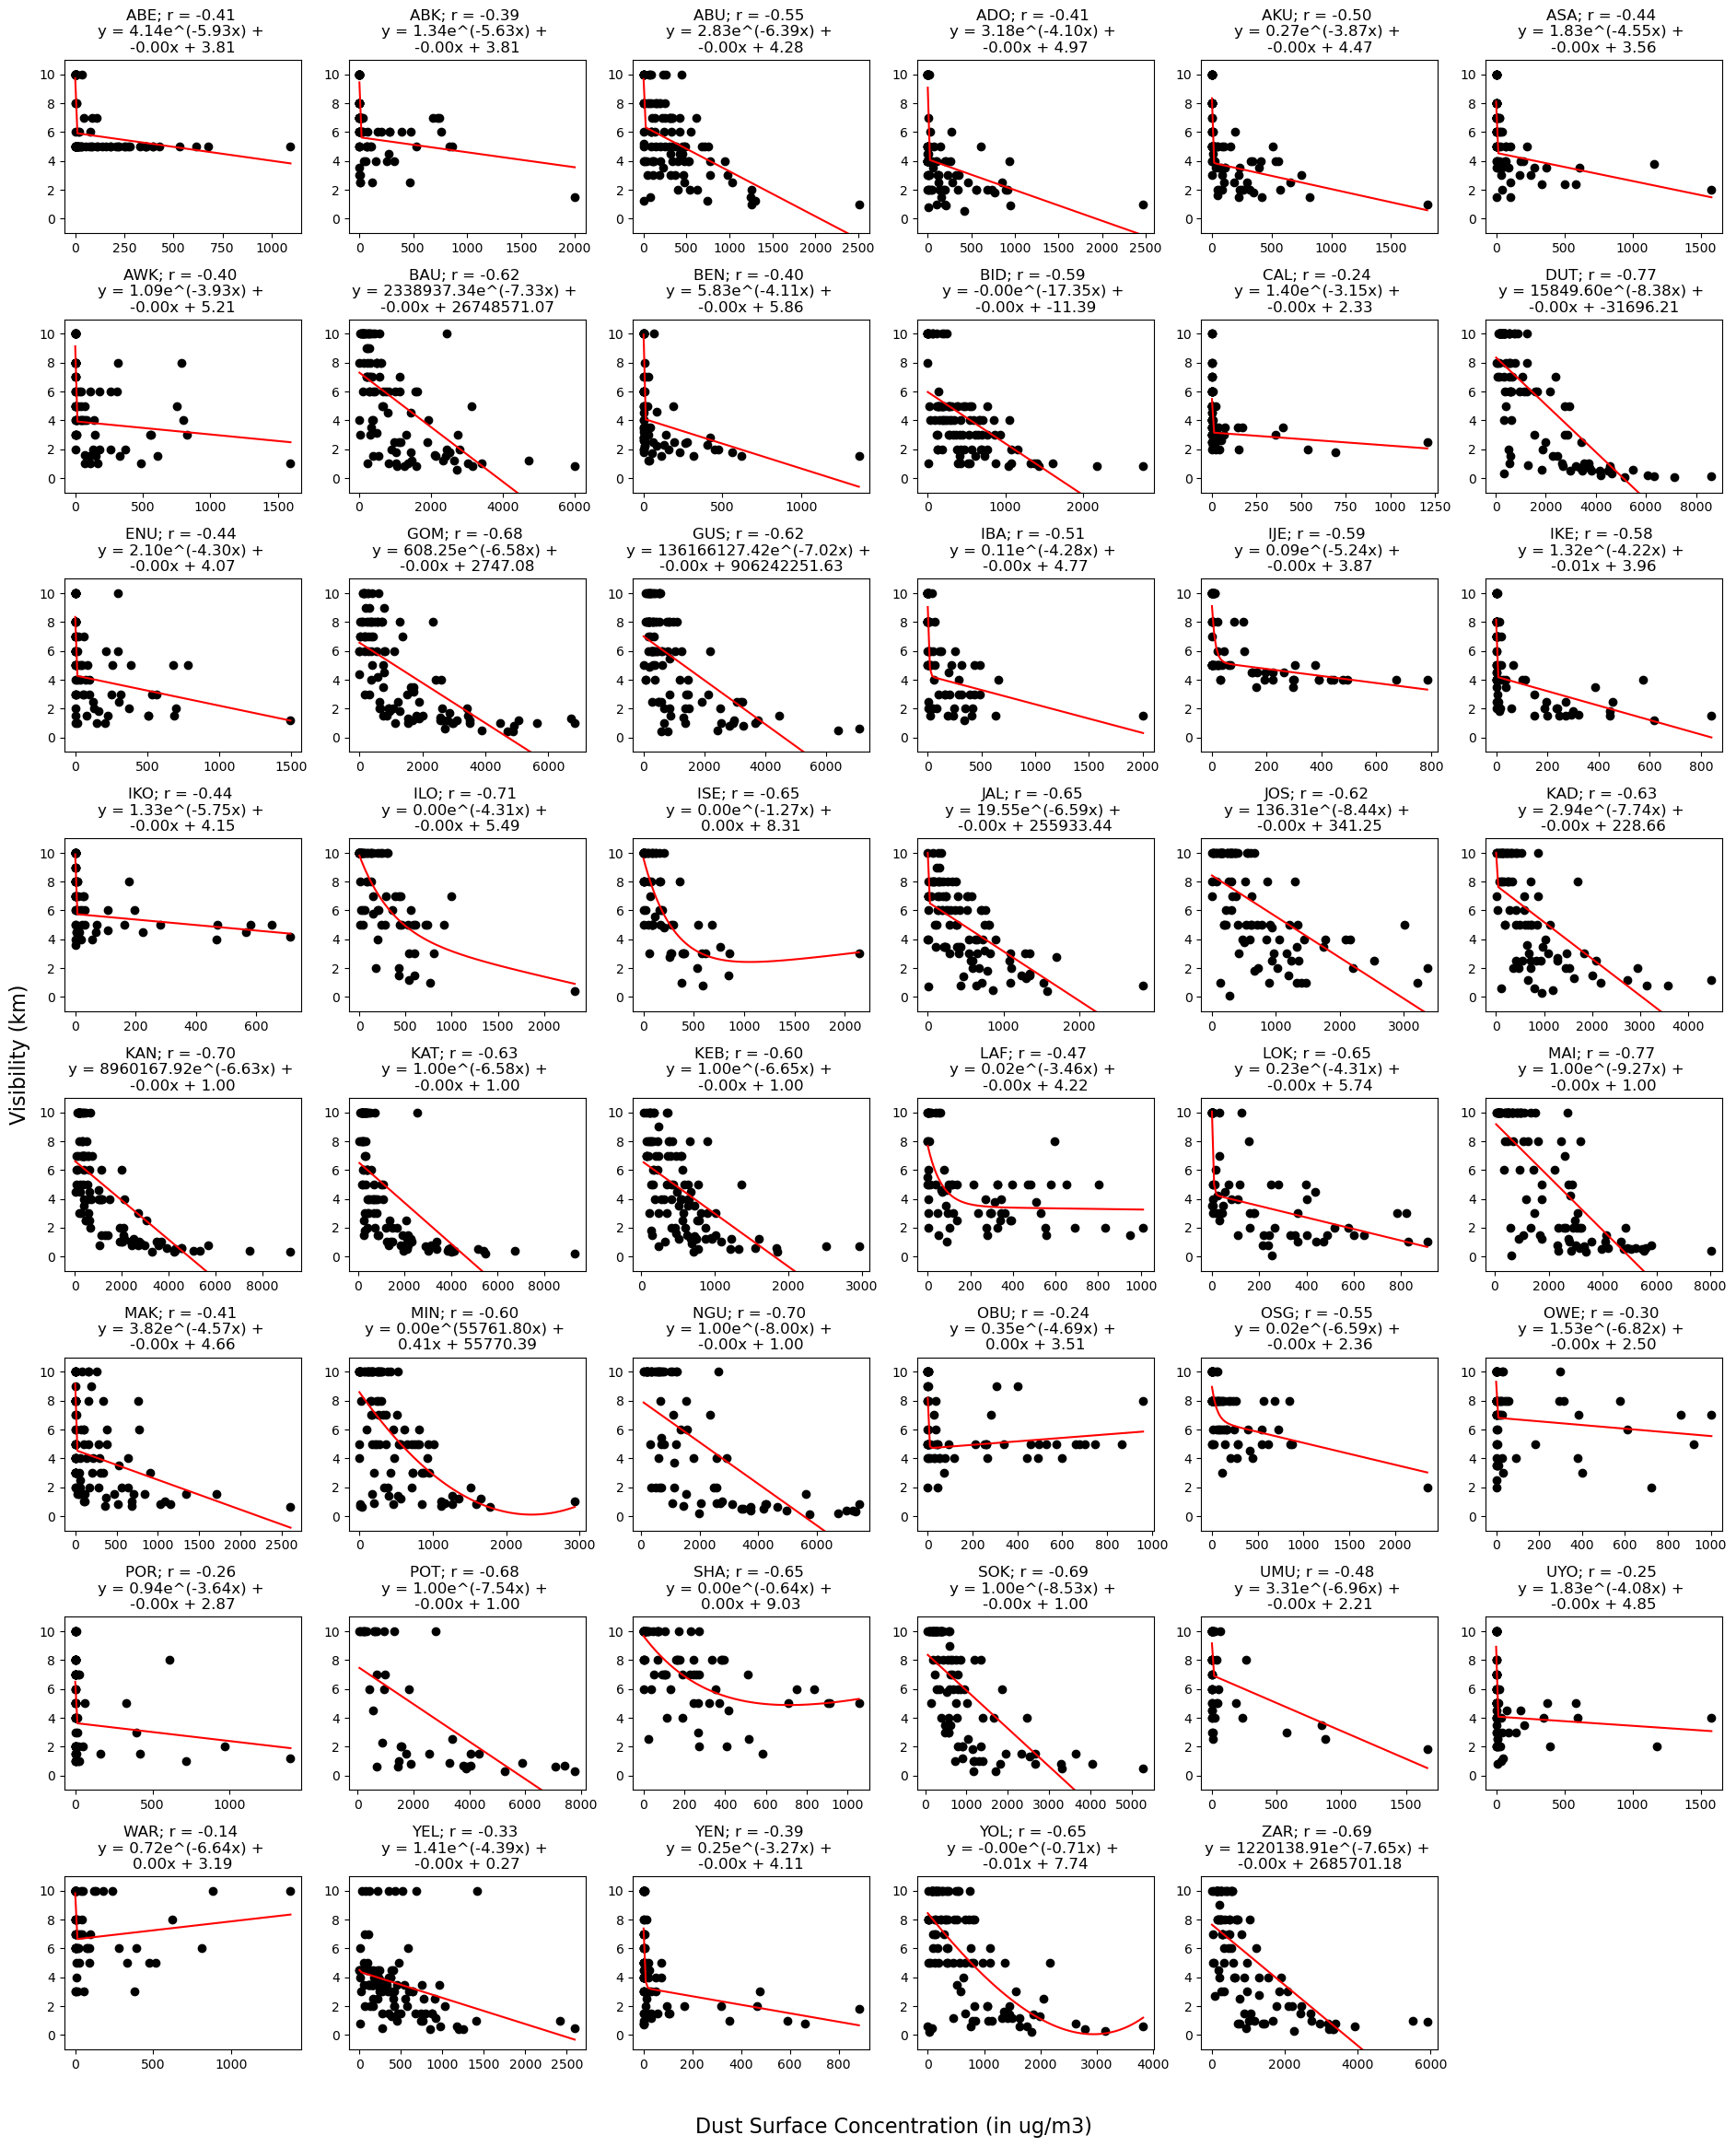

In [10]:
cor_ls = []

fig = plt.figure(figsize=(20, 24))

def exp_func(x, a, b, c, d):
    return a * np.exp(-b * x) + c + d*x

for i, j in enumerate(stn):
    merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
    merged.columns = ["Visibility", "AOD"]
    merged['AOD'] = pd.to_numeric(merged['AOD'], errors='coerce') # convert to numeric type
    ab = merged.dropna()

    # exponential regression part
    popt, pcov = opt.curve_fit(exp_func, ab['AOD'], ab['Visibility'], maxfev=10000)
    exp_fit = exp_func(ab['AOD'], *popt)

    # calculate correlation
    corr = np.corrcoef(ab['AOD'], ab['Visibility'])[0,1]
    p_val = stats.pearsonr(ab['AOD'], ab['Visibility'])[1]

    cor_ls.append([stn_lat[i], stn_lon[i], j, round(corr, 2), round(p_val, 2)])

    ax = fig.add_subplot(8,6,i+1)
    ax.scatter(ab['AOD'], ab['Visibility'], color='k')
    
    x_fitted = np.linspace(np.min(ab['AOD']), np.max(ab['AOD']), 100)
    a = popt[0]
    b = popt[1]
    c = popt[2]
    d = popt[3]
    y_fitted = a * np.exp(-b * x_fitted) + c + d*x_fitted
    
    ax.plot(x_fitted, y_fitted, 'r')
#     title = j + '\n a={:.2f}, b={:.2f}, c={:.2f}, d={:.2f}\n'.format(*popt) + 'corr={:.2f}, p-value={:.2f}'.format(corr, p_val)
#     ax.set_title(title, fontsize=14)
    ax.set_ylim([-1, 11])
    ax.margins(y=0.2)
    
#     ax.set_xlim([0, 1.5])
#     ax.set_ylim([-1, 11])
#     ax.margins(x=0.05, y=0.2)
    equation = j + '; ' + f'r = {corr:.2f} \n' + f'y = {popt[1]:.2f}e^({-popt[2]:.2f}x) + \n{popt[3]:.2f}x + {popt[0]:.2f}'

#     ax.text(0.05, 0.95, equation, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_title(equation, fontsize=12)


plt.subplots_adjust(wspace=0.2, hspace=0.5, top=0.95, bottom=0.05, left=0.05, right=0.95)
# fig.suptitle('Relationship Between Aerosol Optical Depth (AOD) and Visibility', fontsize=20)
fig.supxlabel('Dust Surface Concentration (in ug/m3)', fontsize=16)
fig.supylabel('Visibility (km)', fontsize=16)
plt.savefig('../plots/day1/SILAM.png')

In [11]:
cor_df = pd.DataFrame(cor_ls, columns=["Lat", "Long", "Station", "r_value", "p_value"])
cor_df['p'] = 2
cor_df.loc[cor_df['p_value'] > 0.05, 'p'] = 1
# cor_df

# cor_df.to_csv("cor_files/day1/MULTI MODEL MEDIAN_1d.csv", index=False)
cor_df.to_csv("../plots/day1/SILAM.csv", index=False)
# cor_df.to_csv("cor_files/day3/MULTI MODEL MEDIAN_3d.csv", index=False)